In [64]:
import cv2
import os
import glob

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

CALIBRATION_DIR = 'camera_cal'
TEST_DIR = 'test_images'
UNDISTORTED_DIR = 'undistorted_images'
if not os.path.isdir(UNDISTORTED_DIR):
    os.mkdir(UNDISTORTED_DIR)

In [89]:
def plot_side_by_side(image,
                      comparison):
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(comparison)
    ax2.set_title('Comparison Image', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

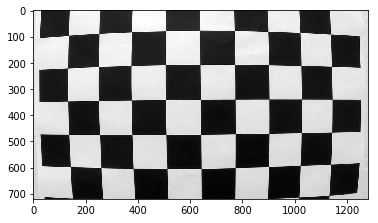

In [2]:
TEST_IMAGE = os.path.join(CALIBRATION_DIR,
                          'calibration1.jpg')
img = cv2.imread(TEST_IMAGE)
gray = cv2.cvtColor(img,
                    cv2.COLOR_BGR2GRAY)

plt.imshow(gray,
           cmap='gray')

In [60]:
def find_corners(file_name,
                 nx,
                 ny):
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    refined_corners = None
    
    img = cv2.imread(file_name)
    grey = cv2.cvtColor(img,
                        cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(grey,
                                             (nx,ny),
                                             None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        print("Corners found")
        refined_corners = cv2.cornerSubPix(grey,
                                           corners,
                                           (11,11),
                                           (-1,-1),
                                           criteria)
        
#         # Draw and display the corners
#         img = cv2.drawChessboardCorners(img, (7,6), refined_corners,ret)
#         plt.imshow(img)
#         cv2.waitKey(500)

    # If you don't find any corners, try again with fewer rows
    if ret == False and nx == 6:
        print("Trying again with fewer rows")
        objp, refined_corners = find_corners(file_name,
                                             nx-1,
                                             ny)
    # If you don't find any corners, try again with fewer columns
    if ret == False and nx == 5:
        print("Trying again with fewer columns")
        objp, refined_corners = find_corners(file_name,
                                             nx,
                                             ny-1)
        
    return objp, refined_corners

In [79]:
NX = 6
NY = 9

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

calibration_image_path = os.path.join(CALIBRATION_DIR,
                               '*.jpg')
# test_image_path = os.path.join(CALIBRATION_DIR,
#                                'calibration1.jpg')
images = glob.glob(calibration_image_path)

for file_name in images:
    print("Processing {}".format(file_name))
    objp, imgp = find_corners(file_name,
                              NX,
                              NY)
    
    objpoints.append(objp)
    imgpoints.append(imgp)

Processing camera_cal/calibration1.jpg
Trying again with fewer rows
Corners found
Processing camera_cal/calibration10.jpg
Corners found
Processing camera_cal/calibration11.jpg
Corners found
Processing camera_cal/calibration12.jpg
Corners found
Processing camera_cal/calibration13.jpg
Corners found
Processing camera_cal/calibration14.jpg
Corners found
Processing camera_cal/calibration15.jpg
Corners found
Processing camera_cal/calibration16.jpg
Corners found
Processing camera_cal/calibration17.jpg
Corners found
Processing camera_cal/calibration18.jpg
Corners found
Processing camera_cal/calibration19.jpg
Corners found
Processing camera_cal/calibration2.jpg
Corners found
Processing camera_cal/calibration20.jpg
Corners found
Processing camera_cal/calibration3.jpg
Corners found
Processing camera_cal/calibration4.jpg
Trying again with fewer rows
Trying again with fewer columns
Trying again with fewer columns
Trying again with fewer columns
Corners found
Processing camera_cal/calibration5.jpg
T

In [62]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

In [80]:
def undistort_image(file_name,
                    save_directory,
                    image,
                    objpoints,
                    imgpoints,
                    matrix,
                    dist,
                    rvecs,
                    tvecs):
    height, width = image.shape[:2]
    
    # Refine camera matrix
    new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(matrix,
                                                           dist,
                                                           (width, height),
                                                           1,
                                                           (width,height))
    
    # Undistort
    undistorted = cv2.undistort(image,
                                matrix,
                                dist,
                                None,
                                new_camera_matrix)

    # crop the image
    x, y, new_width, new_height = roi
    undistorted = undistorted[y:y+new_height, x:x+new_width]
    
    # Save image
    undistorted_file_name = os.path.join(save_directory,
                                         file_name.split('/')[-1])
    cv2.imwrite(undistorted_file_name,
                undistorted)

    total_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i],
                                          rvecs[i],
                                          tvecs[i], 
                                          matrix,
                                          dist)
        error = cv2.norm(imgpoints[i],
                         imgpoints2,
                         cv2.NORM_L2) / len(imgpoints2)
        total_error += error

    mean_error = total_error / len(objpoints)
    
    return mean_error

In [83]:
total_error = 0.

test_image_path = os.path.join(TEST_DIR,
                               '*.jpg')
images = glob.glob(test_image_path)

for file_name in images:
    image = cv2.imread(file_name)
    error = undistort_image(file_name,
                            UNDISTORTED_DIR,
                            image,
                            objpoints,
                            imgpoints,
                            mtx,
                            dist,
                            rvecs,
                            tvecs)
    total_error += error
    
print("The average image error is {}".format(total_error / len(images)))

The average image error is 0.11555696344556035


In [118]:
def apply_colour_mask(image,
                      threshold_low,
                      threshold_high):
    binary_image = np.zeros_like(image[:,:,0])
    
    binary_image[(image[:, :, 0] >= threshold_low[0]) & (image[:, :, 0] <= threshold_high[0]) & \
                 (image[:, :, 1] >= threshold_low[1]) & (image[:, :, 1] <= threshold_high[1]) & \
                 (image[:, :, 2] >= threshold_low[2]) & (image[:, :, 2] <= threshold_high[2])] = 1
    
    return binary_image

In [119]:
def abs_sobel_thresh(img,
                     orient='x',
                     sobel_kernel=3,
                     thresh=(0, 255)):
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

def mag_thresh(image,
               sobel_kernel=3,
               mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(image,
                  sobel_kernel=3,
                  thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [124]:
def detect_lines(image):
    """ Following approach taken in this tutorial 
        https://medium.com/towards-data-science/robust-lane-finding-using-advanced-computer-vision-techniques-mid-project-update-540387e95ed3
    """
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    yellow_hsv_low  = np.array([ 0, 80, 200])
    yellow_hsv_high = np.array([ 40, 255, 255])
    yellow_binary = apply_colour_mask(hsv_image,
                                      yellow_hsv_low,
                                      yellow_hsv_high)
    
    white_hsv_low  = np.array([  20,   0,   200])
    white_hsv_high = np.array([ 255,  80, 255])
    white_binary = apply_colour_mask(hsv_image,
                                     white_hsv_low,
                                     white_hsv_high)
    
    hls_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS).astype(np.float)
    sat_hls_low  = np.array([  0,   0,   90])
    sat_hls_high = np.array([ 255,  255, 255])
    sat_binary = apply_colour_mask(hls_image,
                                   sat_hls_low,
                                   sat_hls_high)
    
    combined_binary = np.zeros_like(white_binary)
    combined_binary[(yellow_binary == 1) | (white_binary == 1) | (sat_binary == 1)] = 1
    
    # Convert to HLS color space and separate the V channel
    l_channel = hls_image[:,:,1]
    s_channel = hls_image[:,:,2]
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(s_channel, orient='x', sobel_kernel=ksize, thresh=(0, 255))
    grady = abs_sobel_thresh(s_channel, orient='y', sobel_kernel=ksize, thresh=(0, 255))
    mag_binary = mag_thresh(s_channel, sobel_kernel=ksize, mag_thresh=(0, 255))
    dir_binary = dir_threshold(s_channel, sobel_kernel=ksize, thresh=(0, np.pi/2))
    
    combined = np.zeros_like(combined_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

In [125]:
image = cv2.imread('undistorted_images/straight_lines1.jpg',
                   cv2.IMREAD_COLOR)
plot_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
binary = detect_lines(image)

plot_side_by_side(plot_image,
                  binary)

error: /Users/jenkins/miniconda/1/x64/conda-bld/work/opencv-3.1.0/modules/imgproc/src/color.cpp:7935: error: (-215) depth == CV_8U || depth == CV_16U || depth == CV_32F in function cvtColor
